## Setup

In [357]:
import os
import importlib
from tqdm import tqdm

# Torch modules
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch import amp

# Custom modules
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import preprocessing, model_utils

import segmentation.dataset
importlib.reload(segmentation.dataset)
from segmentation.dataset import PointDataset

from models.unet_model import UNET

import segmentation_models_pytorch as smp

In [358]:
# Defining some constants that will be used throughout the notebook
DATA_DIR = 'Dataset/'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')
x_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/color')
y_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/label')

# Splitting into training and validation
# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)

# Splitting relative path names into into training and validation
x_train_fps, x_val_fps, y_train_fps, y_val_fps = preprocessing.train_val_split(x_trainVal_dir, y_trainVal_dir, 0.2)

In [359]:
# Creating the dataset
train_augmentation = preprocessing.get_training_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
val_augmentation = preprocessing.get_validation_augmentation()

train_dataset = PointDataset(x_train_fps, y_train_fps, augmentation=train_augmentation, preprocessing=preprocessing_fn, concat_heatmap=False)
val_dataset  = PointDataset(x_val_fps, y_val_fps, augmentation=val_augmentation, preprocessing=preprocessing_fn)

train_loader = DataLoader(train_dataset,batch_size= 8,num_workers=4,pin_memory=True,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size= 8,num_workers=4,pin_memory=True,shuffle=False)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [360]:
import numpy as np
np.unique(mask)

array([  0, 128, 255], dtype=uint8)

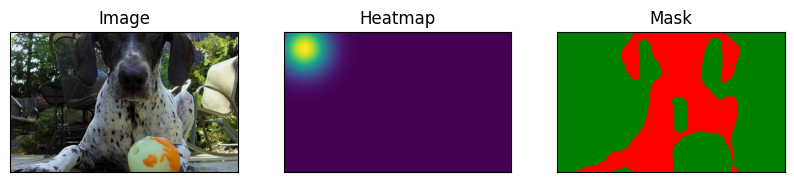

In [375]:
import importlib.readers
from segmentation.show import *
import segmentation.constants
importlib.reload(segmentation.constants)
from segmentation.constants import VisualisationConstants

image, mask, heatmap = train_dataset[100]
mask = colorise_mask(mask, palette=VisualisationConstants.palette)
visualise_data(image = image, heatmap = heatmap, mask = mask)

In [281]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    '''
    One epoch of training
    '''
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device = DEVICE,  dtype=torch.float32)
        targets = targets.long().unsqueeze(1).to(device = DEVICE)

        # forward
        with torch.autocast(device_type=DEVICE, dtype=torch.float16):
            targets = targets.to(device = DEVICE).squeeze(1)  # Now masks is (N,H,W)
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss = loss.item())

def validate_fn(loader, model, loss_fn):
    model.eval()  # set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device=DEVICE, dtype=torch.float32)
            targets = targets.long().unsqueeze(1).to(device=DEVICE)
            with torch.autocast(device_type=DEVICE, dtype=torch.float16):
                # squeeze targets to get shape (N, H, W)
                predictions = model(data)
                loss = loss_fn(predictions, targets.squeeze(1))
            total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    model.train()  # set model back to training mode
    return avg_loss


def train_and_evaluate(model, optimizer, train_loader, valid_loader, loss_fn, num_epochs):
    '''
    Trains the model for a given set of hyperparameters and evaluates it.
    '''
    scaler = amp.GradScaler()
    best_val_loss = 100

    for epoch in range(num_epochs):
        # ... training loop ....
        train_fn(train_loader, model, optimizer, loss_fn, scaler)
        checkpoint = {'state_dict': model.state_dict()}

        val_loss = validate_fn(valid_loader, model, loss_fn)
        print(f'validation loss: {val_loss}')

        # Saving if the validation loss is better
        if val_loss < best_val_loss:
            model_utils.save_checkpoint(checkpoint)
            best_val_loss = val_loss


    



In [ ]:
model = UNET(in_channels=4, out_channels=4).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
#dice_loss = smp.losses.DiceLoss(mode='binary', smooth=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


train_and_evaluate(model=model,
                   optimizer=optimizer,
                   train_loader=train_loader,
                   valid_loader=val_loader,
                   loss_fn = loss_fn,
                   num_epochs=5
                   )

/opt/miniconda3/envs/cv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|          | 0/1 [00:17<?, ?it/s]

: 

## Mid Fusion

In [9]:
# Creating the dataset
train_augmentation = preprocessing.get_training_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
val_augmentation = preprocessing.get_validation_augmentation()

train_dataset = PointDataset(x_train_fps, y_train_fps, augmentation=train_augmentation, preprocessing=preprocessing_fn, concat_heatmap=False)
val_dataset  = PointDataset(x_val_fps, y_val_fps, augmentation=val_augmentation, preprocessing=preprocessing_fn, concat_heatmap= False)

train_loader = DataLoader(train_dataset,batch_size= 8,num_workers=4,pin_memory=True,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size= 8,num_workers=4,pin_memory=True,shuffle=False)

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    '''
    One epoch of training
    '''
    loop = tqdm(loader)

    for batch_idx, (data, targets, heatmap) in enumerate(loop):
        data = data.to(device = DEVICE,  dtype=torch.float32)
        heatmap = heatmap.to(device = DEVICE, dtype = torch.float32)
        targets = targets.long().unsqueeze(1).to(device = DEVICE)

        # forward
        with torch.autocast(device_type=DEVICE, dtype=torch.float16):
            targets = targets.to(device = DEVICE).squeeze(1)  # Now masks is (N,H,W)
            print(f'targets has shape {targets.shape}')
            predictions = model(data, heatmap)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss = loss.item())

def validate_fn(loader, model, loss_fn):
    model.eval()  # set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        for data, targets, heatmap in loader:
            data = data.to(device=DEVICE, dtype=torch.float32)
            heatmap = heatmap.to(device = DEVICE, dtype = torch.float32)
            targets = targets.long().unsqueeze(1).to(device=DEVICE)
            with torch.autocast(device_type=DEVICE, dtype=torch.float16):
                # squeeze targets to get shape (N, H, W)
                predictions = model(data, heatmap)
                loss = loss_fn(predictions, targets.squeeze(1))
            total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    model.train()  # set model back to training mode
    return avg_loss


def train_and_evaluate(model, optimizer, train_loader, valid_loader, loss_fn, num_epochs):
    '''
    Trains the model for a given set of hyperparameters and evaluates it.
    '''
    scaler = amp.GradScaler()
    best_val_loss = 100

    for epoch in range(num_epochs):
        # ... training loop ....
        train_fn(train_loader, model, optimizer, loss_fn, scaler)
        # checkpoint = {'state_dict': model.state_dict()}

        # val_loss = validate_fn(valid_loader, model, loss_fn)
        # print(f'validation loss: {val_loss}')

        # # Saving if the validation loss is better
        # if val_loss < best_val_loss:
        #     model_utils.save_checkpoint(checkpoint)
        #     best_val_loss = val_loss


    



In [12]:
from models.mid_fusion_unet import MidFusionUNET
model = MidFusionUNET()
dice_loss = smp.losses.DiceLoss(mode='binary', smooth=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_and_evaluate(model=model,
                   optimizer=optimizer,
                   train_loader=train_loader,
                   valid_loader=val_loader,
                   loss_fn = dice_loss,
                   num_epochs=5
                   )

/opt/miniconda3/envs/cv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  2%|▏         | 9/368 [00:07<03:43,  1.61it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


  8%|▊         | 29/368 [00:07<00:44,  7.66it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 14%|█▍        | 53/368 [00:08<00:16, 19.30it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 18%|█▊        | 65/368 [00:08<00:11, 26.92it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 24%|██▍       | 89/368 [00:08<00:06, 44.87it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 31%|███       | 113/368 [00:08<00:04, 62.70it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 34%|███▍      | 125/368 [00:08<00:03, 69.88it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 40%|████      | 149/368 [00:09<00:02, 83.64it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8,

 47%|████▋     | 173/368 [00:09<00:02, 91.96it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 54%|█████▎    | 197/368 [00:09<00:01, 95.32it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 60%|█████▉    | 219/368 [00:09<00:01, 94.35it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 62%|██████▏   | 229/368 [00:10<00:01, 89.03it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 69%|██████▉   | 253/368 [00:10<00:01, 89.92it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 75%|███████▌  | 277/368 [00:10<00:00, 95.37it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8,

 82%|████████▏ | 301/368 [00:10<00:00, 97.08it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 85%|████████▌ | 313/368 [00:10<00:00, 96.41it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 91%|█████████ | 335/368 [00:11<00:00, 93.14it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 96%|█████████▋| 355/368 [00:11<00:00, 92.32it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])


 99%|█████████▉| 365/368 [00:11<00:00, 89.79it/s]

targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([8, 256, 416])
targets has shape torch.Size([2, 256, 416])


100%|██████████| 368/368 [00:12<00:00, 28.52it/s]


KeyboardInterrupt: 

In [17]:
image = torch.randn((1, 3, 161, 161))
guidance = torch.randn((1, 1, 161, 161))
model = MidFusionUNET()
preds = model(image, guidance)